In [1]:
import pandas
from pandas import DataFrame
import numpy
import matplotlib.pyplot as plt

Gọi Dữ liệu
--- 

In [3]:
#%run GETAPI.ipynb  #for calling data

Xử lý dữ liệu đọc thêm tại file [Data exploration](Q_Data_Exploration.ipynb)

Đọc dữ liệu
---

In [2]:
symbols = pandas.read_csv('Data/symbols.csv')
data = pandas.read_csv('Data/data.csv')
f_data = pandas.read_csv('Data/token_price.csv')

try:
    symbols = symbols.drop(['Unnamed: 0'], axis=1)
except:
    pass
try:
    data = data.drop(['Unnamed: 0'], axis=1)
except:
    pass
try:
    f_data = f_data.drop(['Unnamed: 0'], axis=1)
except:
    pass
base_coin = ['BUSD','USDT'] # đồng tiền ổn định giá

## Trả lời một sô câu hỏi

------

### Xem sự liên quan giữa giá và số lượng giao dịch

In [35]:
f_data[['base','Open price','High price','Low price','Close price','Number of trades']].groupby('base').mean().corr()

,Open price,High price,Low price,Close price,Number of trades
Open price,1.000000,1.000000,1.000000,1.000000,0.665169
High price,1.000000,1.000000,0.999999,1.000000,0.665176
Low price,1.000000,0.999999,1.000000,1.000000,0.665132
Close price,1.000000,1.000000,1.000000,1.000000,0.665142
Number of trades,0.665169,0.665176,0.665132,0.665142,1.000000


Độ tương quan khá thấp, nên có thể thấy số lượng giao dịch không có ảnh hưởng nhiều đến giá của đồng coin

---

### Kiểm tra xem giá trị quy đổi giữa các token với nhau, có tuân theo giá trị thực không

In [36]:
head_name = data.columns

In [39]:
def GetPrice(sym):
    for i in base_coin:
        temp = f_data[(f_data.base == sym) & (f_data.quote == i)]
        if temp.shape[0] !=0:
            return temp.set_index('Kline open time')[head_name[4:8]]
    return 1

In [42]:
temp = data.set_index(["Symbol","Kline open time"]).drop(head_name[8:],axis=1)
temp # xep lai data phan theo tung loại dao dich

base quote  Open price  High price  Low price  \
Symbol  Kline open time                                                  
ETHBTC  1669395600000     ETH   BTC    0.072026    0.072222   0.072026   
        1669397400000     ETH   BTC    0.072222    0.072335   0.072117   
        1669399200000     ETH   BTC    0.072163    0.072263   0.072101   
        1669401000000     ETH   BTC    0.072188    0.072261   0.072161   
        1669402800000     ETH   BTC    0.072223    0.072479   0.072197   
...                       ...   ...         ...         ...        ...   
BUSDRON 1670943600000    BUSD   RON    4.629000    4.630000   4.620000   
        1670945400000    BUSD   RON    4.620000    4.631000   4.620000   
        1670947200000    BUSD   RON    4.631000    4.631000   4.630000   
        1670949000000    BUSD   RON    4.630000    4.631000   4.630000   
        1670950800000    BUSD   RON    4.631000    4.631000   4.630000   

                         Close price  
Symbol  Kline open time               
ETHBTC  1669395600000       0.072222  
        1669397400000       0.072162  
        1669399200000       0.072189  
        1669401000000       0.072212  
        1669402800000       0.072375  
...                              ...  
BUSDRON 1670943600000       4.621000  
        1670945400000       4.630000  
        1670947200000       4.631000  
        1670949000000       4.631000  
        1670950800000       4.631000  

[1229162 rows x 6 columns]

In [43]:
diff = []
for i in set(temp.index.get_level_values(0)):
    baseA  =  symbols[symbols.symbol==i].baseAsset.values[0]
    quoteA = symbols[symbols.symbol==i].quoteAsset.values[0]
    cal = GetPrice(baseA) / GetPrice(quoteA)
    try:
        gap = numpy.nanmean(cal - temp.loc[i][head_name[4:8]],axis=0) #differenct between price
        # % of gap to total
        gap /= numpy.mean(temp.loc[i][head_name[4:8]],axis=0)
        diff += [gap]        
    except:
        diff += [[0,0,0,0]]
    pass

In [ ]:
numpy.mean(diff,axis = 0)

array([0.02731673, 0.02641888, 0.02802794, 0.02729723])

Sự chênh lệch nằm ở tầm 2-3% (dương) giá trị token, có thể nói khi trao đổi thông qua đồng tiền nền thì ta sẽ mất nhiều phí hơn là trao đổi trực tiếp giữa 2 token với nhau, nhưng đồng thời cũng cho thấy được là giá trị quy đổi các token có tuân theo giá trị thực của chúng

------

### Xem sét 1 đồng tiền cụ thể (ETH) để xem giao dịch có làm ảnh hưởng đến giá trị không

In [44]:
#tong so luong giao dich co lien quan den dong ETH theo thoi gian
ETH_price_trade =pandas.concat( [GetPrice('ETH'), data[(data.base == 'ETH' )|(data.quote == 'ETH')].groupby("Kline open time").sum()[["Number of trades"]]],axis = 1)
ETH_price_trade.corr()["Number of trades"]

Open price         -0.020199
High price          0.068455
Low price          -0.059944
Close price         0.017932
Number of trades    1.000000
Name: Number of trades, dtype: float64

Có thể thấy không có nhiều sự liên quan giữa số lượng giao dịch và giá đối với đồng tiền ETH này <br>
xem xét biểu đồ dưới đây

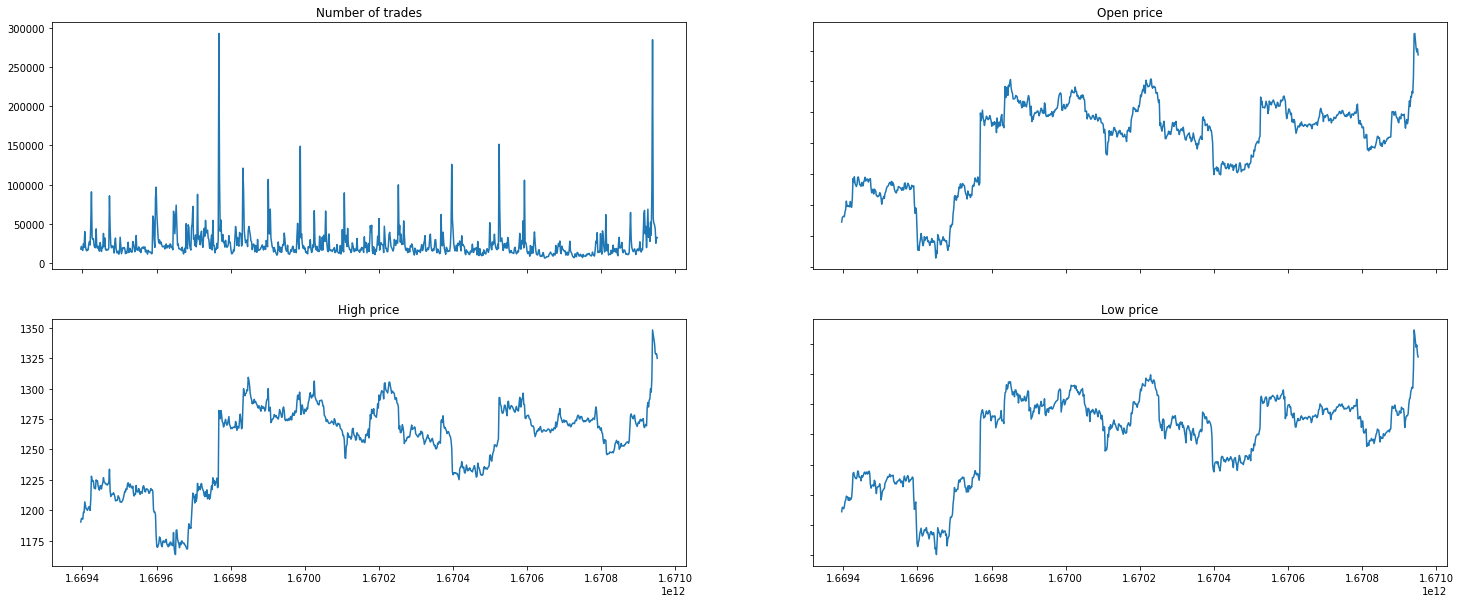

In [47]:
fig, axs = plt.subplots(2, 2,figsize=(25, 10))
axs[0, 0].plot(ETH_price_trade["Number of trades"])
axs[0, 0].set_title('Number of trades')
axs[0, 1].plot(ETH_price_trade["Open price"])
axs[0, 1].set_title('Open price')
axs[1, 0].plot(ETH_price_trade["High price"])
axs[1, 0].set_title('High price')
axs[1, 1].plot(ETH_price_trade["Low price"])
axs[1, 1].set_title('Low price')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Tuy nhiên, nếu chúng ta để ý thì tại những mốc có lượng giao dịch vượt trội (mode), thì giá của đồng ETH này cũng biến động lớn ở thời điểm gần như tương tự, thế nên số lương giao dịch, đôi khi cũng phải ảnh được các cột mốc quan trọng trong biến động giá của token
____

### câu 4

## Model

In [3]:
data.groupby("Kline open time").count().Symbol.unique() # the size in each time range is not the same
# so what should we do ?
# only take token that have in fully time

array([1418, 1422, 1425, 1426], dtype=int64)

In [4]:
check = data.groupby("Symbol").count()["Kline open time"]
full_time_token = check[check == data["Kline open time"].nunique()].index

In [5]:
data_set = data[data.Symbol.isin(full_time_token)].set_index("Kline open time").drop(["base","quote","Kline Close time","Unused field, ignore"],axis=1)
time_set = data["Kline open time"].unique()

In [6]:
X = data_set.iloc[data_set.Symbol.argsort()].loc[time_set].drop("Symbol",axis=1).to_numpy().flatten().reshape((len(time_set),-1)) # now make all data in a 

In [9]:
X.shape

(865, 12762)

In [106]:
def getColOftoken(arr,token:str,col):
    if type(col) != int:
        col = {"Open price" : 0,
        "High price" : 1,
        "Low price" : 2,
        "Close price" : 3,
        "Volume" :4,
        "Quote asset volume" :5,
        "Number of trades" :6,
        "Taker buy base asset volume" : 7,
        "Taker buy quote asset volume" :8}[col]
    return arr[:,full_time_token.to_list().index(token)*9 + col]

In [8]:
X_set,y_set =  X[:-1],X[1:]

In [323]:
y_set = y_set - X_set > 0

In [324]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X_set,y_set,test_size=0.3,shuffle=False) #because it time series, so i dont want to split

In [326]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred =  y_pred >= 0

LinearRegression()

In [349]:
sum((y_pred[:,0] == y_test[:,0]).flatten())/ y_test.shape[0] , sum((y_pred == y_test).flatten())/ (y_test.shape[0]* y_test.shape[1])  # đoán toàn bộ

(0.4230769230769231, 0.4927962219570118)

In [353]:
sum((y_pred[:10,0] == y_test[:10,0]).flatten())/ 10 , sum((y_pred[:10] == y_test[:10]).flatten())/ (10* y_test.shape[1]) #chỉ đoán 1 phàn gần tập train nhất

(0.4, 0.5020843128036357)

xấu hơn cả đoán bừa

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [109]:
temp = getColOftoken(X,"BTCUSDT","Open price")

In [110]:
temp = temp[1:] - temp[:-1]

In [113]:
temp[np.isclose(temp,0)] = 0
temp[temp>0] = 1
temp[temp<0] = -1

In [79]:
X_set.shape , y_set.shape

((864, 12762), (864, 12762))

In [91]:
temp = np.sum(_y[:,:9],axis = 1)
temp[temp>0] = 1
temp[temp<0] = -1

In [116]:
from sklearn import svm

gnb = svm.SVC()
gnb.fit(X_set,temp)

SVC()

In [117]:
pred = gnb.predict(X_set)

In [118]:
from sklearn.metrics import classification_report
print(classification_report(pred,temp))

              precision    recall  f1-score   support

        -1.0       0.12      0.73      0.20        67
         1.0       0.96      0.54      0.69       797

    accuracy                           0.55       864
   macro avg       0.54      0.63      0.44       864
weighted avg       0.89      0.55      0.65       864



Không khá hơn là bao